# **Khởi tạo**

**Import thư viện**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

**Xử lý dữ liệu**

In [9]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)

    return data

**Xây dựng mô hình**

In [10]:
def build_and_evaluate_model(file_name, train_ratio=0.7, test_ratio=0.2, forecast_days=30):
    # Đọc dữ liệu từ file CSV
    df = read_file(file_name)
    df1 = df.reset_index()['Price']
    # Scaler data
    scaler = MinMaxScaler(feature_range=(0,1))
    df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
    # Chia train, test
    train_size = int(train_ratio * len(df1))
    test_size = int(test_ratio * len(df1))
    train_data = df1[:train_size]
    test_data = df1[train_size:train_size+test_size]
    # Hàm Create Dataset
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    # Define LSTM Model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    # Đánh giá độ chính xác thuật toán bằng RMSE
    train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Train RMSE:', train_rmse)
    print('Testing RMSE:', test_rmse)
   # Dự báo n ngày tiếp theo
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < forecast_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())

    # Vẽ hình
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, y_pred)
    predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+forecast_days, step=1)
    plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
    plt.legend(['Train', 'Test', 'Predict', f'Predict {forecast_days} days'])
    plt.show()

# **BIDV**

**BIDV 7:3 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0412  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8796e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011    
Epoch 

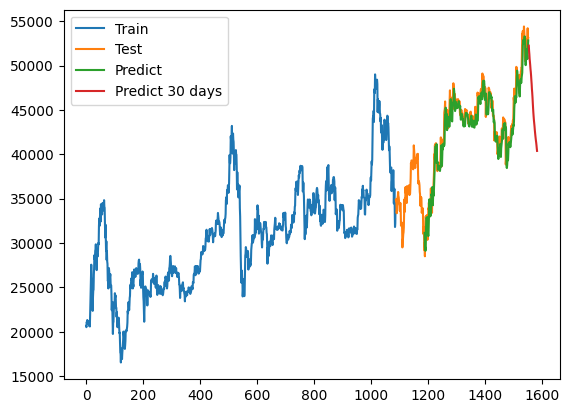

In [11]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**BIDV 7:3 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0632 
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017    
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012    
Epoch 1

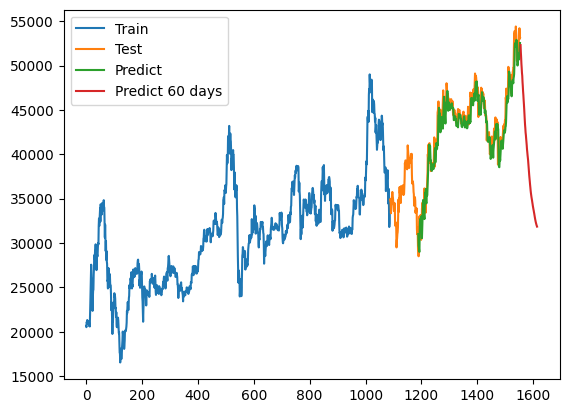

In [12]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**BIDV 7:3 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2685
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018    
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017   
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 1

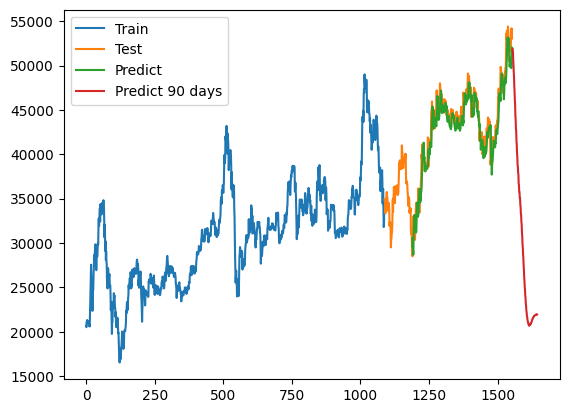

In [13]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**BIDV 8:2 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0255
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010    
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.7586e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.1571e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3300e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5282e-04 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9055e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.8522e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6701e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 

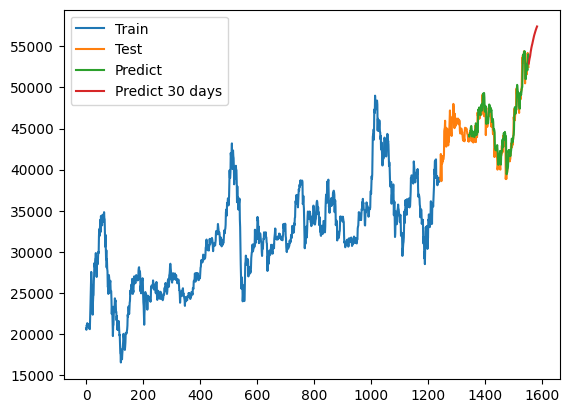

In [14]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**BIDV 8:2 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9228 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0054
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0036
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0034
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0029
E

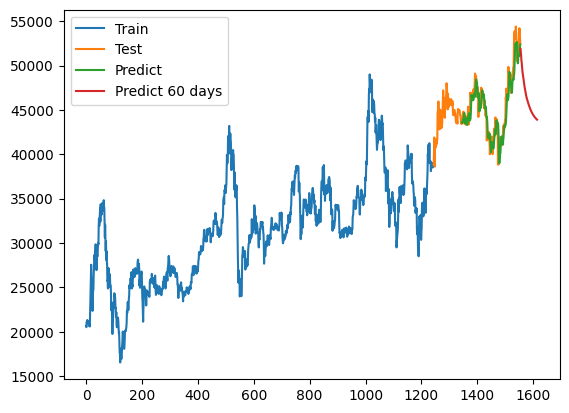

In [15]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**BIDV 8:2 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0793
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epo

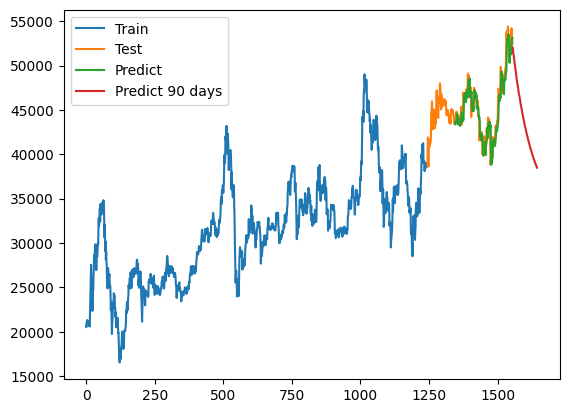

In [16]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**BIDV 9:1 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1656
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
E

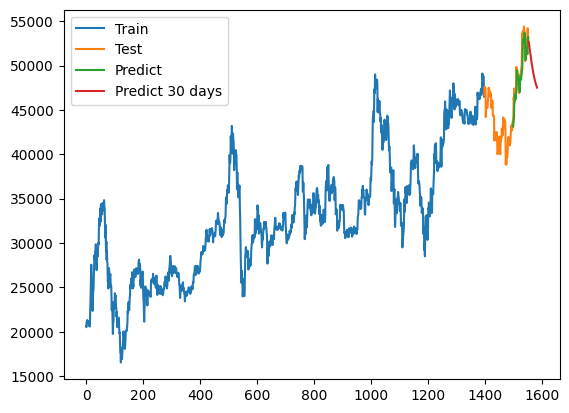

In [17]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

**BIDV 9:1 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1696
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8676e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9300e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4252e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7965e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0105e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.1030e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15

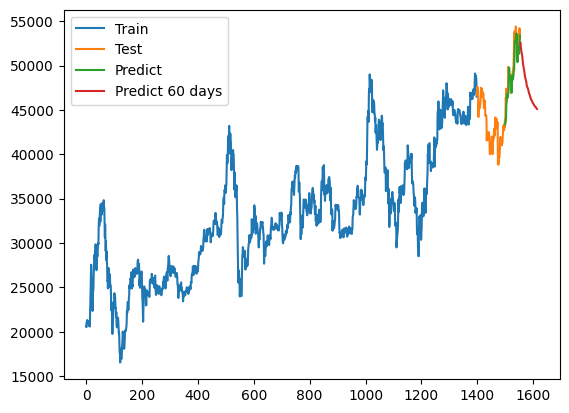

In [18]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

**BIDV 9:1 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2355 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0112
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0017
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Ep

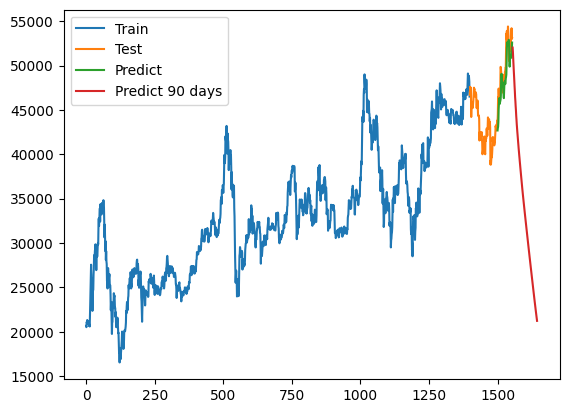

In [19]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **MBB**

**MBB 7:3 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1011 
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010    
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7705e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6567e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4081e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7314e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/ste

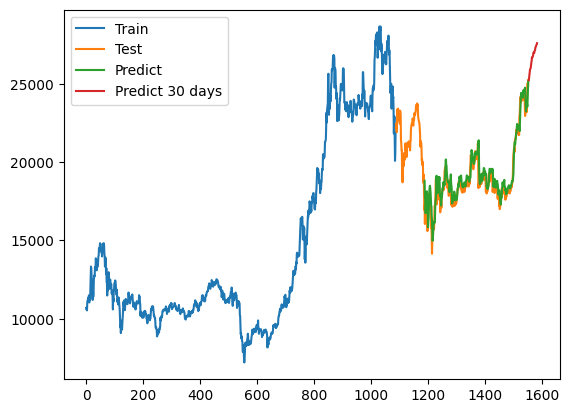

In [20]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**MBB 7:3 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1134  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4816e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0709e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8361e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7148e-04 
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0726e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6370e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9339e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4259e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1100e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7311e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 

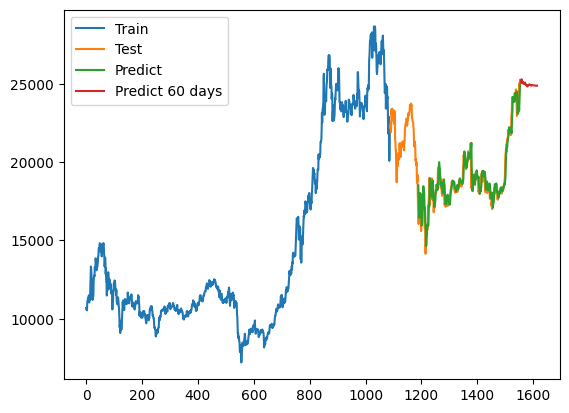

In [21]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**MBB 7:3 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0419  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8743e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6611e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3665e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5379e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6721e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9932e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2858e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2000e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6863e-04 
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8293e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9925e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4166e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━

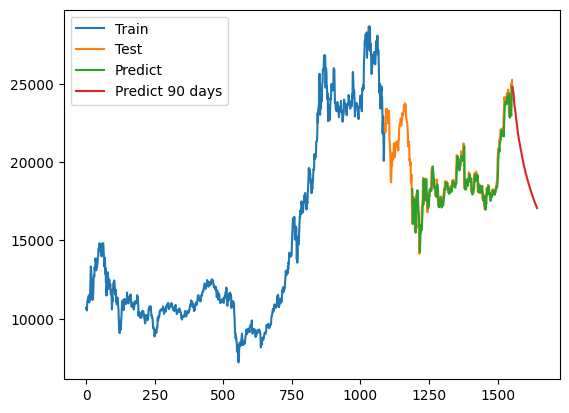

In [22]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**MBB 8:2 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6707 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024
Epoch 16/1

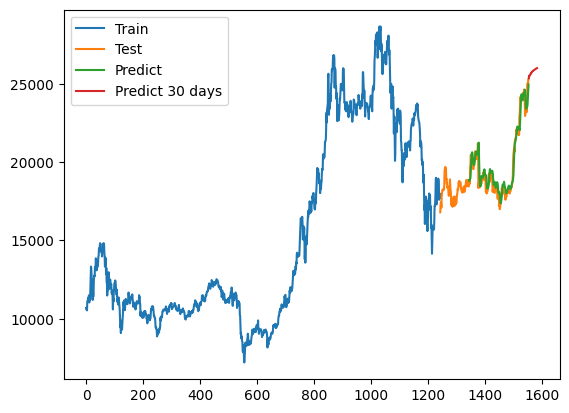

In [23]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**MBB 8:2 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0230
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.2027e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.0860e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.7804e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.8751e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0524e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0187e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7761e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1262e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6914e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8961e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.3357e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0493e-04
Epoch 15/100
18/18 ━━

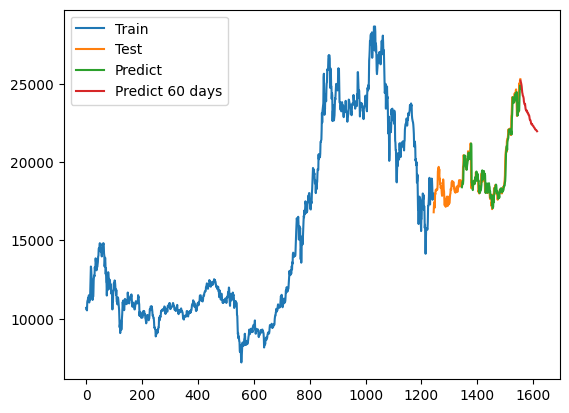

In [24]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**MBB 8:2 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0646
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.9933e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.4117e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.2305e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.0500e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

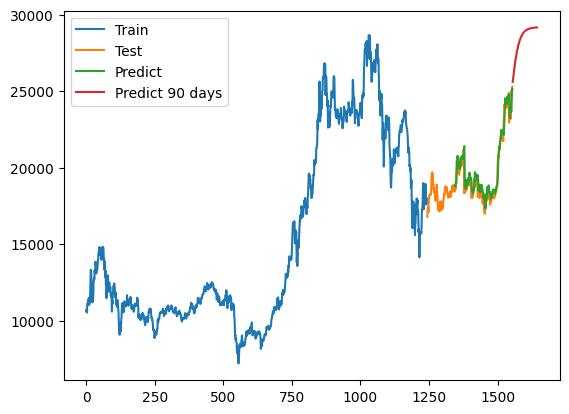

In [25]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**MBB 9:1 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0035
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.3376e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7437e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5381e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.0520e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.0535e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.6840e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.3432e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2073e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4454e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2622e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.4670e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2199e-04
Epoch 15/100
21/21 ━━

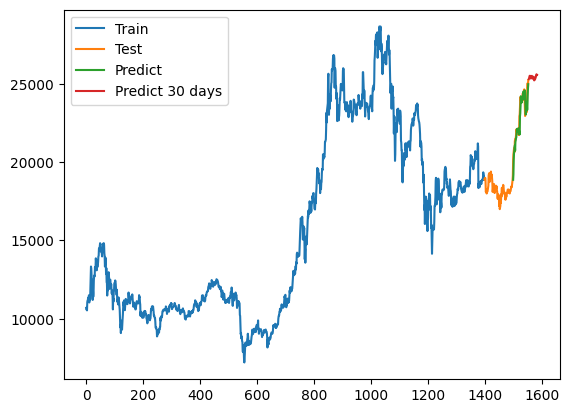

In [26]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

**MBB 9:1 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0837
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0010
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.5595e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.00

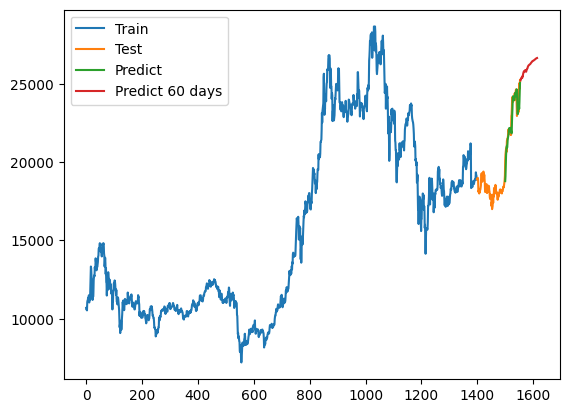

In [27]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

**MBB 9:1 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3688
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.5162e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9815e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9906e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8694e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8947e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3948e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7756e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1216e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1688e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2305e-04
Epoch 15/100
21/21 ━━━━━━━━━━━

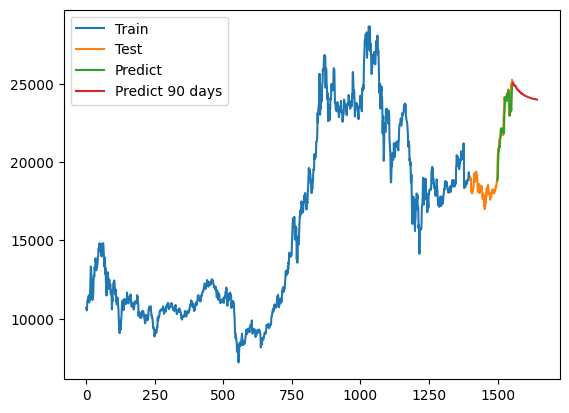

In [28]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **VCB**

**VCB 7:3 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2353
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.3459e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4863e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.9244e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5298e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

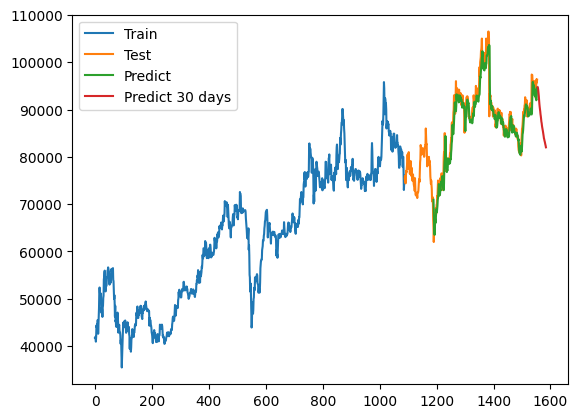

In [29]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**VCB 7:3 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0758
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010  
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.4229e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.1868e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.0098e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0903e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/ste

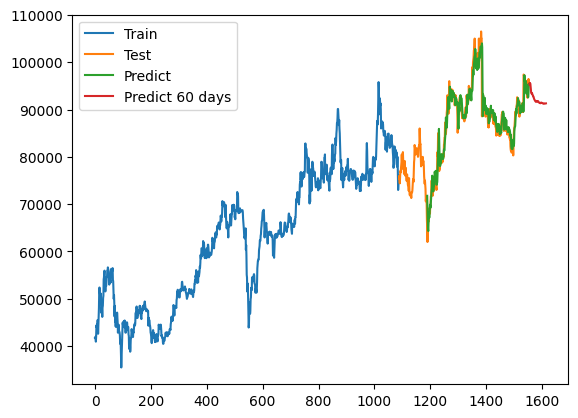

In [30]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**VCB 7:3 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0244
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.7492e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.8215e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.6726e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8897e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9347e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/st

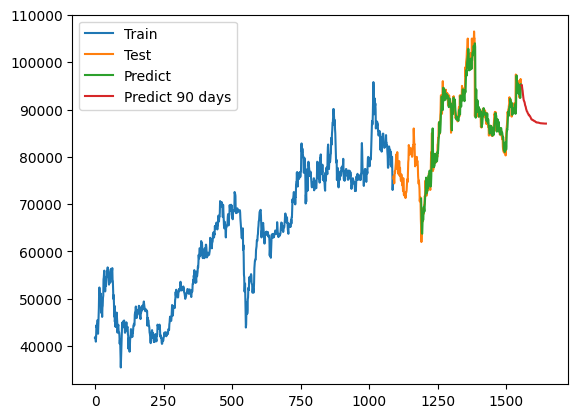

In [31]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**VCB 8:2 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2842
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.9549e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.5191e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.7999e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.7548e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.7615e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.1798e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14

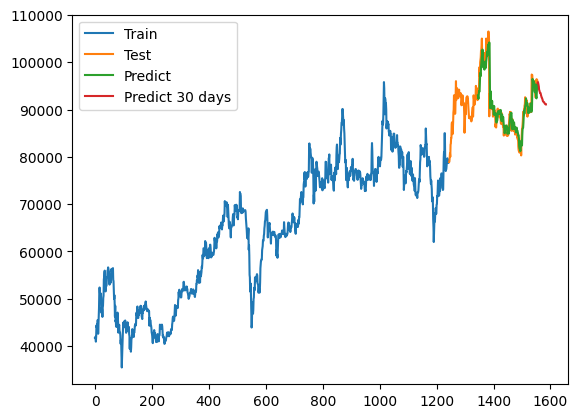

In [32]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**VCB 8:2 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0990
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0237e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0632e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6230e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1842e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.9561e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.6148e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.5545e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.9623e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━

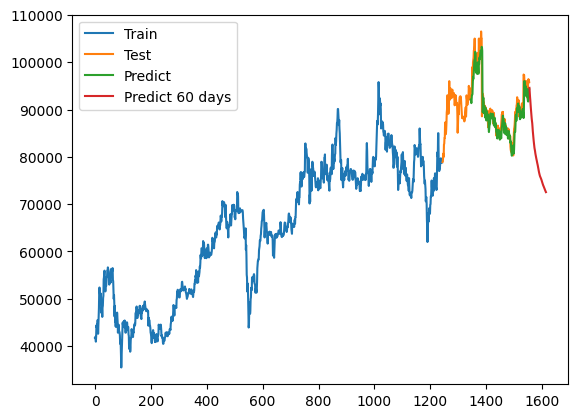

In [33]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**VCB 8:2 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1482
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0050
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.4739e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.7610e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.3885e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.4940e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.6910e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.7855e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8430e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9194e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.4439e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━

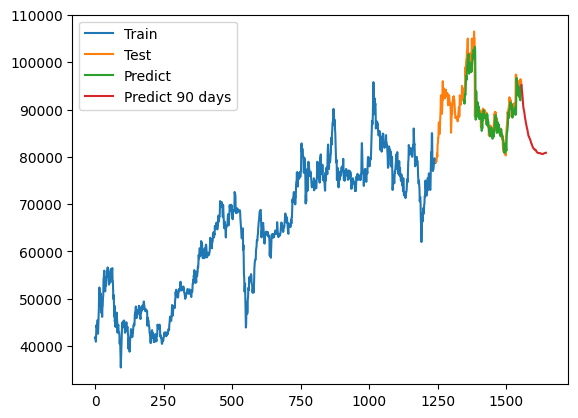

In [34]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**VCB 9:1 predict 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1203
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.3202e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.8698e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.1904e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.3748e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.3822e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2957e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4518e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.6170e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.9043e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.9196e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8866e-04
Epoch 15/100
21/21 ━━━━━━

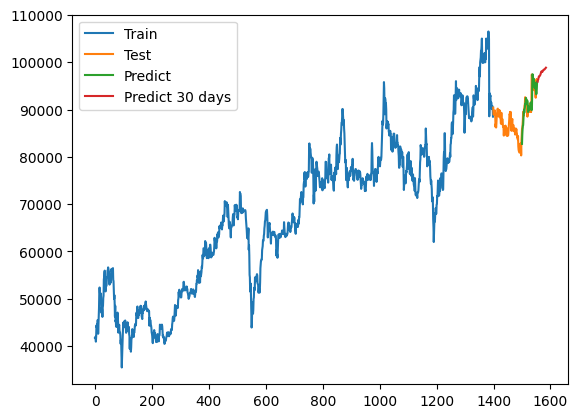

In [35]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

**VCB 9:1 predict 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0129
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.8677e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.3121e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.3899e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.2077e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8361e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.4823e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.5846e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6942e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1757e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8344e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3267e-04
Epoch 15/100
21/21 ━━━━━━

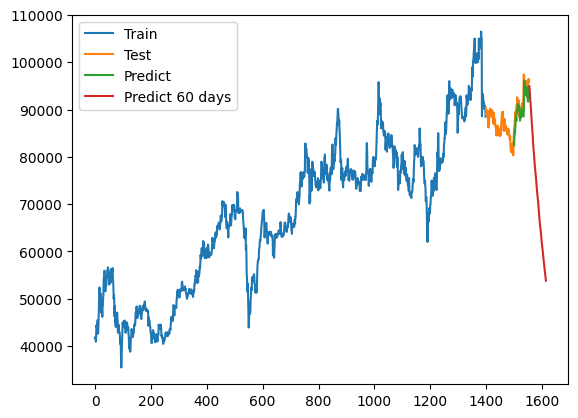

In [36]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

**VCB 9:1 predict 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3009 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 16/100
21

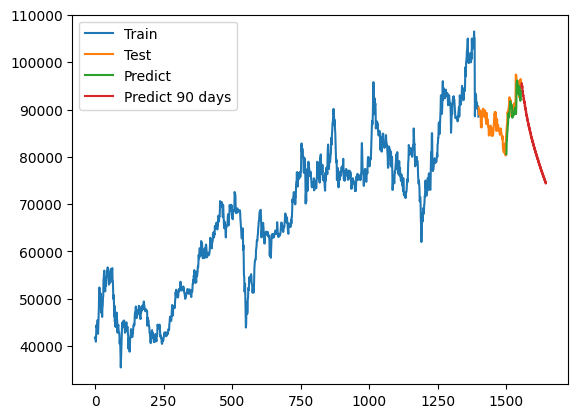

In [37]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)